## Imports

In [1]:
# IMPORTS
import torch
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import libs.forward_model as fm
import libs.read_data as rd
import numpy as np
import libs.visualizer as vs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Model

In [2]:
# Parameter Definition
NA = 1.2
Rindex= 1.5
lambda_= 532.0/ 1000 #um
dx, dy, dz = 1/3, 1/3, 1#um
ep_dx, ep_dy = 2, 2 #um

Nx,Ny,Nz = 120,120,21

fm.init_parameters(NA_=NA, Rindex_=Rindex, lambda_=lambda_, dx_=dx, dy_=dy, dz_=dz, Nx_=Nx, Ny_=Ny, Nz_=Nz)
fm.init_DMD(ep_dx_=ep_dx, ep_dy_=ep_dy)
rd.init_parameters(Nx,Ny,Nz, dx , dy, dz)

Sucessfully Initialized Point Spread Function...!!!
Sucessfully Initialized Read Data Parameters...!!!


### Forward Model

$$ H_1(x,y,z) = H(x,y,z=z_f)\ \star_{\tiny 3D}\ \texttt{exPSF}(x,y,z) \qquad\to\qquad H_2(x,y,z) = \|H_1(x,y,z)\|$$ 



$$H_3(x,y,z) = X(x,y,z) \circ H_2(x,y,z) \qquad \to \qquad Y(x,y,z) = \texttt{emPSF}(x,y,z)\ \star_{\tiny 3D}\ H_3(x,y,z)$$

The $\texttt{exPSF}(.)$ is modelled considering the coherance nature of laser light whereas the $\texttt{emPSF}(.)$ is defined in a incoherant manner<br>

Fluroscense bead data could be downloaded [here.](https://bigwww.epfl.ch/deconvolution/bead/)

Shapes of vectors
 exPSF: torch.Size([3, 21, 120, 120])
 H1: torch.Size([3, 21, 120, 120])
 H2: torch.Size([21, 120, 120])
 emPSF: torch.Size([1, 21, 120, 120])
 H3: torch.Size([1, 21, 120, 120])


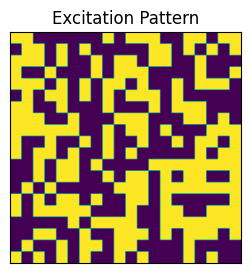

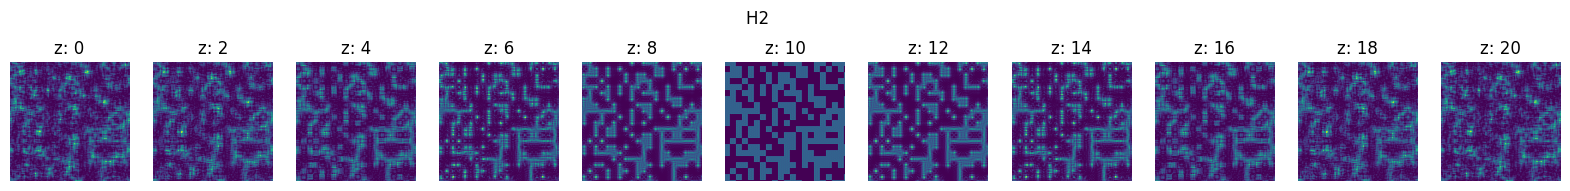

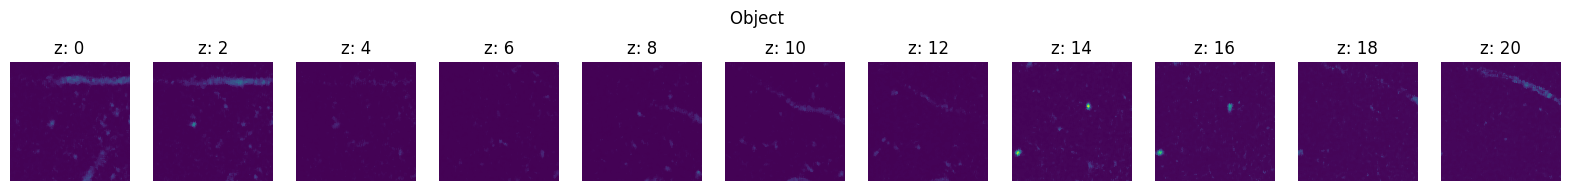

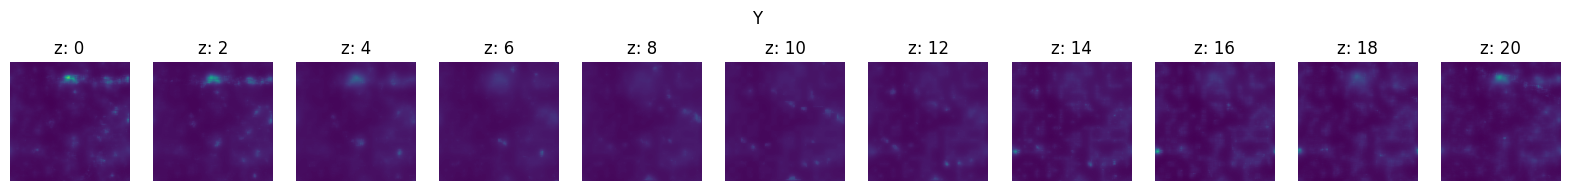

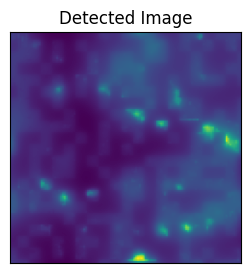

In [3]:
rd.load_object("blood_cell")   # Data Choices --> [blood_cell, neural_cell, bead, 3D_sphere]
det_img_orig = fm.forward_model(rd.X, verbose=4)

## Approximation of A

$$Y_{\tiny N_x\cdot N_y\cdot m\times1} = A_{\tiny N_x\cdot N_y\cdot m\times N_x\cdot N_y\cdot N_z}\cdot X_{\tiny N_x\cdot N_y\cdot N_z\times 1}$$

In [2]:
# Parameter Definition
NA = .8
Rindex= 1
lambda_= 532.0/ 1000 #um
dx, dy, dz = 1/3, 1/3, 1 #um
ep_dx, ep_dy = 1., 1. #um

Nx,Ny,Nz = 16,16,8
m = 8
down_factor = 1

fm.init_parameters(NA_=NA, Rindex_=Rindex, lambda_=lambda_, dx_=dx, dy_=dy, dz_=dz, Nx_=Nx, Ny_=Ny, Nz_=Nz)
fm.init_DMD_patterns(m, ep_dx__=ep_dx, ep_dy__=ep_dy)
rd.init_parameters(Nx,Ny,Nz,dx,dy,dz)

Sucessfully Initialized Point Spread Function...!!!
Sucessfully Initialized Read Data Parameters...!!!


In [3]:
fm.init_one_shot(m,down_factor = down_factor,save_mat=True)
def one_shot_model(X):
    return torch.matmul(fm.A,X)

Plane Calculations: 100%|██████████| 8/8 [00:13<00:00,  1.64s/it]

Matrix A is intialized sucessfully...!!!


### Visualization and Verification of A

***Visualization of A***

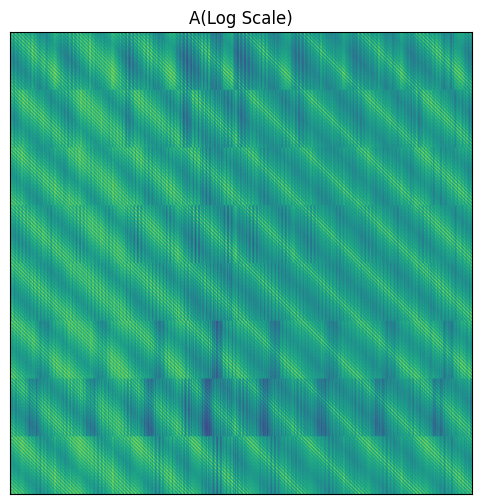

In [5]:
A_ = fm.A.detach().cpu().numpy()
A_[A_==0] = 1e-30
A_ = np.log(A_)
vs.show_image(A_,fig_size=(6,6),title="A(Log Scale)")

***Verification of A***

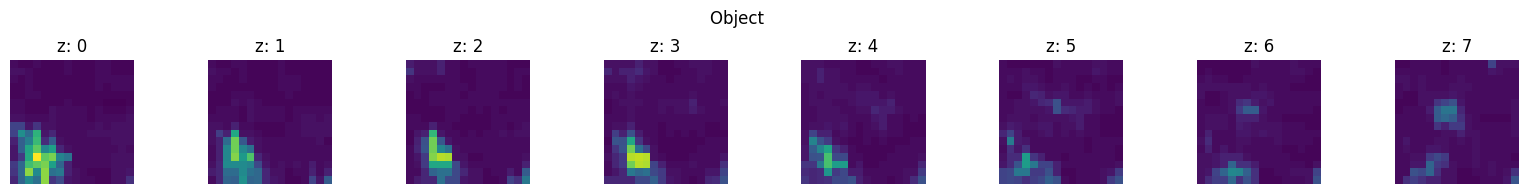

In [4]:
rd.load_object('blood_cell')
vs.show_planes(rd.X[0].detach().cpu().numpy(),'Object',Nz)


In [5]:
Y1 = fm.extended_forward_model(rd.X)
Y2 = one_shot_model(rd.X.flatten())
vs.compare_two_vectors(Y1.detach().cpu(), Y2.detach().cpu())


The vectors are approximately the same.


## Experiments

***Effect of Center Plane: Neural Data***

In [ ]:
# Parameter Definition
NA = 1.2
Rindex= 1.5
lambda_= 532.0/ 1000 #um
dx, dy, dz = 1/3, 1/3, 1#um
ep_dx, ep_dy = 2, 2 #um

Nx,Ny,Nz = 32, 32, 21

fm.init_parameters(NA_=NA, Rindex_=Rindex, lambda_=lambda_, dx_=dx, dy_=dy, dz_=dz, Nx_=Nx, Ny_=Ny, Nz_=Nz)
rd.init_parameters(Nx,Ny,Nz, dx , dy, dz)
rd.load_object('blood_cell')
fm.init_DMD_patterns(m=8, ep_dx__=ep_dx,ep_dy__=ep_dy)

### Experiment-I: Understanding the Spread of Embedding 

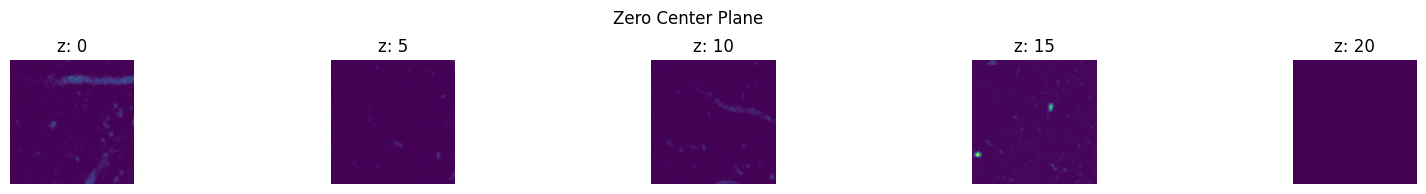

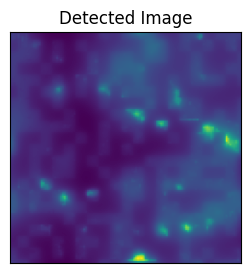

SSIM(Original, Maksed Center Plane) : 1.0


In [7]:
X_e1 = rd.X.clone()
X_e1[0,18:22,:,:] = 0
vs.show_planes_z(X_e1.detach().cpu().numpy()[0,:,:,:],"Zero Center Plane",[0,5,10,15,20])
det_img_e1=fm.forward_model(rd.X,verbose=1)
print(f"SSIM(Original, Maksed Center Plane) : {ssim(det_img_orig.detach().cpu().float().numpy(),det_img_e1.detach().cpu().float().numpy(),data_range=1e-10)}")

***Only the Center Plane is Non-Zero***

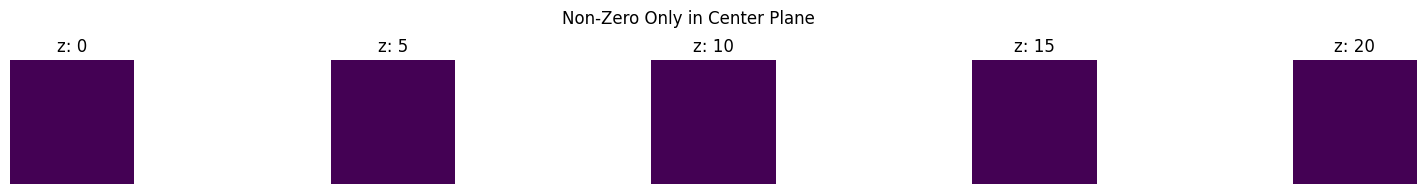

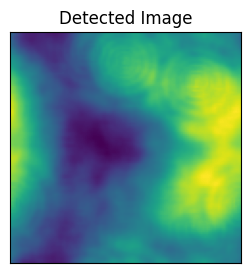

SSIM(Original, Focal Plane Object) : 0.0011941446076565215


In [10]:
X_e2 = rd.X.clone()
X_e2[0,:19,:,:] = 0
X_e2[0,20:,:,:] = 0
vs.show_planes_z(X_e2.detach().cpu().numpy()[0,:,:,:],"Non-Zero Only in Center Plane",[0,5,10,15,20])
det_img_e2=fm.forward_model(X_e2,verbose = 1)
print(f"SSIM(Original, Focal Plane Object) : {ssim(det_img_orig.detach().cpu().float().numpy(),det_img_e2.detach().cpu().float().numpy(),data_range=1e-10)}")

***Slice-wise Comparision***

Mask Out z=0	->   z=4,	 SSIM_score = 0.9227911667881743 
Mask Out z=4	->   z=8,	 SSIM_score = 0.9827043466194295 
Mask Out z=8	->   z=12,	 SSIM_score = 0.49596974599413407 
Mask Out z=12	->   z=16,	 SSIM_score = 0.8978216730456241 
Mask Out z=16	->   z=20,	 SSIM_score = 0.931514695062018 
Mask Out z=20	->   z=24,	 SSIM_score = 0.9961572865745991 


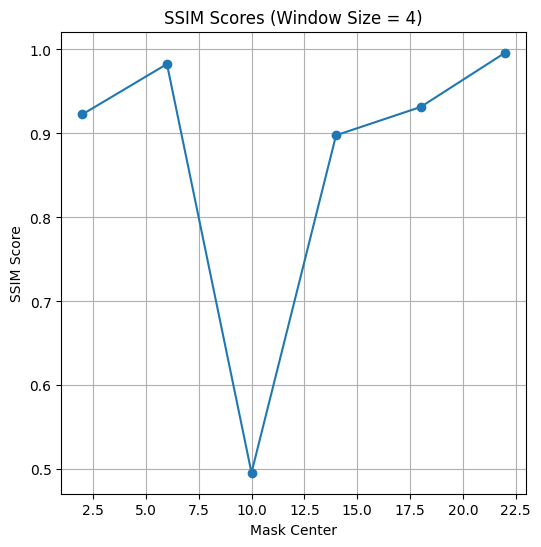

In [11]:
SSIM_list = []
mask_centers = []
ws = 4 # WINDOWSIZE

for mask in range(Nz//ws+1):
    X_exp = rd.X.clone()
    X_exp[0,mask*ws:(mask+1)*ws,:,:] = 0
    det_img_exp = fm.forward_model(X_exp)
    SSIM_score = ssim(det_img_orig.detach().cpu().float().numpy(),det_img_exp.detach().cpu().float().numpy(),data_range=1e-2)
    SSIM_list.append(SSIM_score), mask_centers.append(mask*ws+ws/2)
    print(f"Mask Out z={mask*ws}\t->   z={(mask+1)*ws},\t SSIM_score = {SSIM_score} ")

vs.visualize_SSIM([SSIM_score], [mask_centers], title=f'SSIM Scores (Window Size = {ws})', x_label="Mask Center")


### Experiment-II: Model Depedance on Each Plane

Sucessfully Initialized Point Spread Function...!!!
Sucessfully Initialized Read Data Parameters...!!!


Plane Calculations: 100%|██████████| 21/21 [02:28<00:00,  7.09s/it]


Matrix A is intialized sucessfully...!!!


Plane20, Excitation Pattern: 100%|██████████| 8/8 [00:00<00:00, 1141.11it/s]


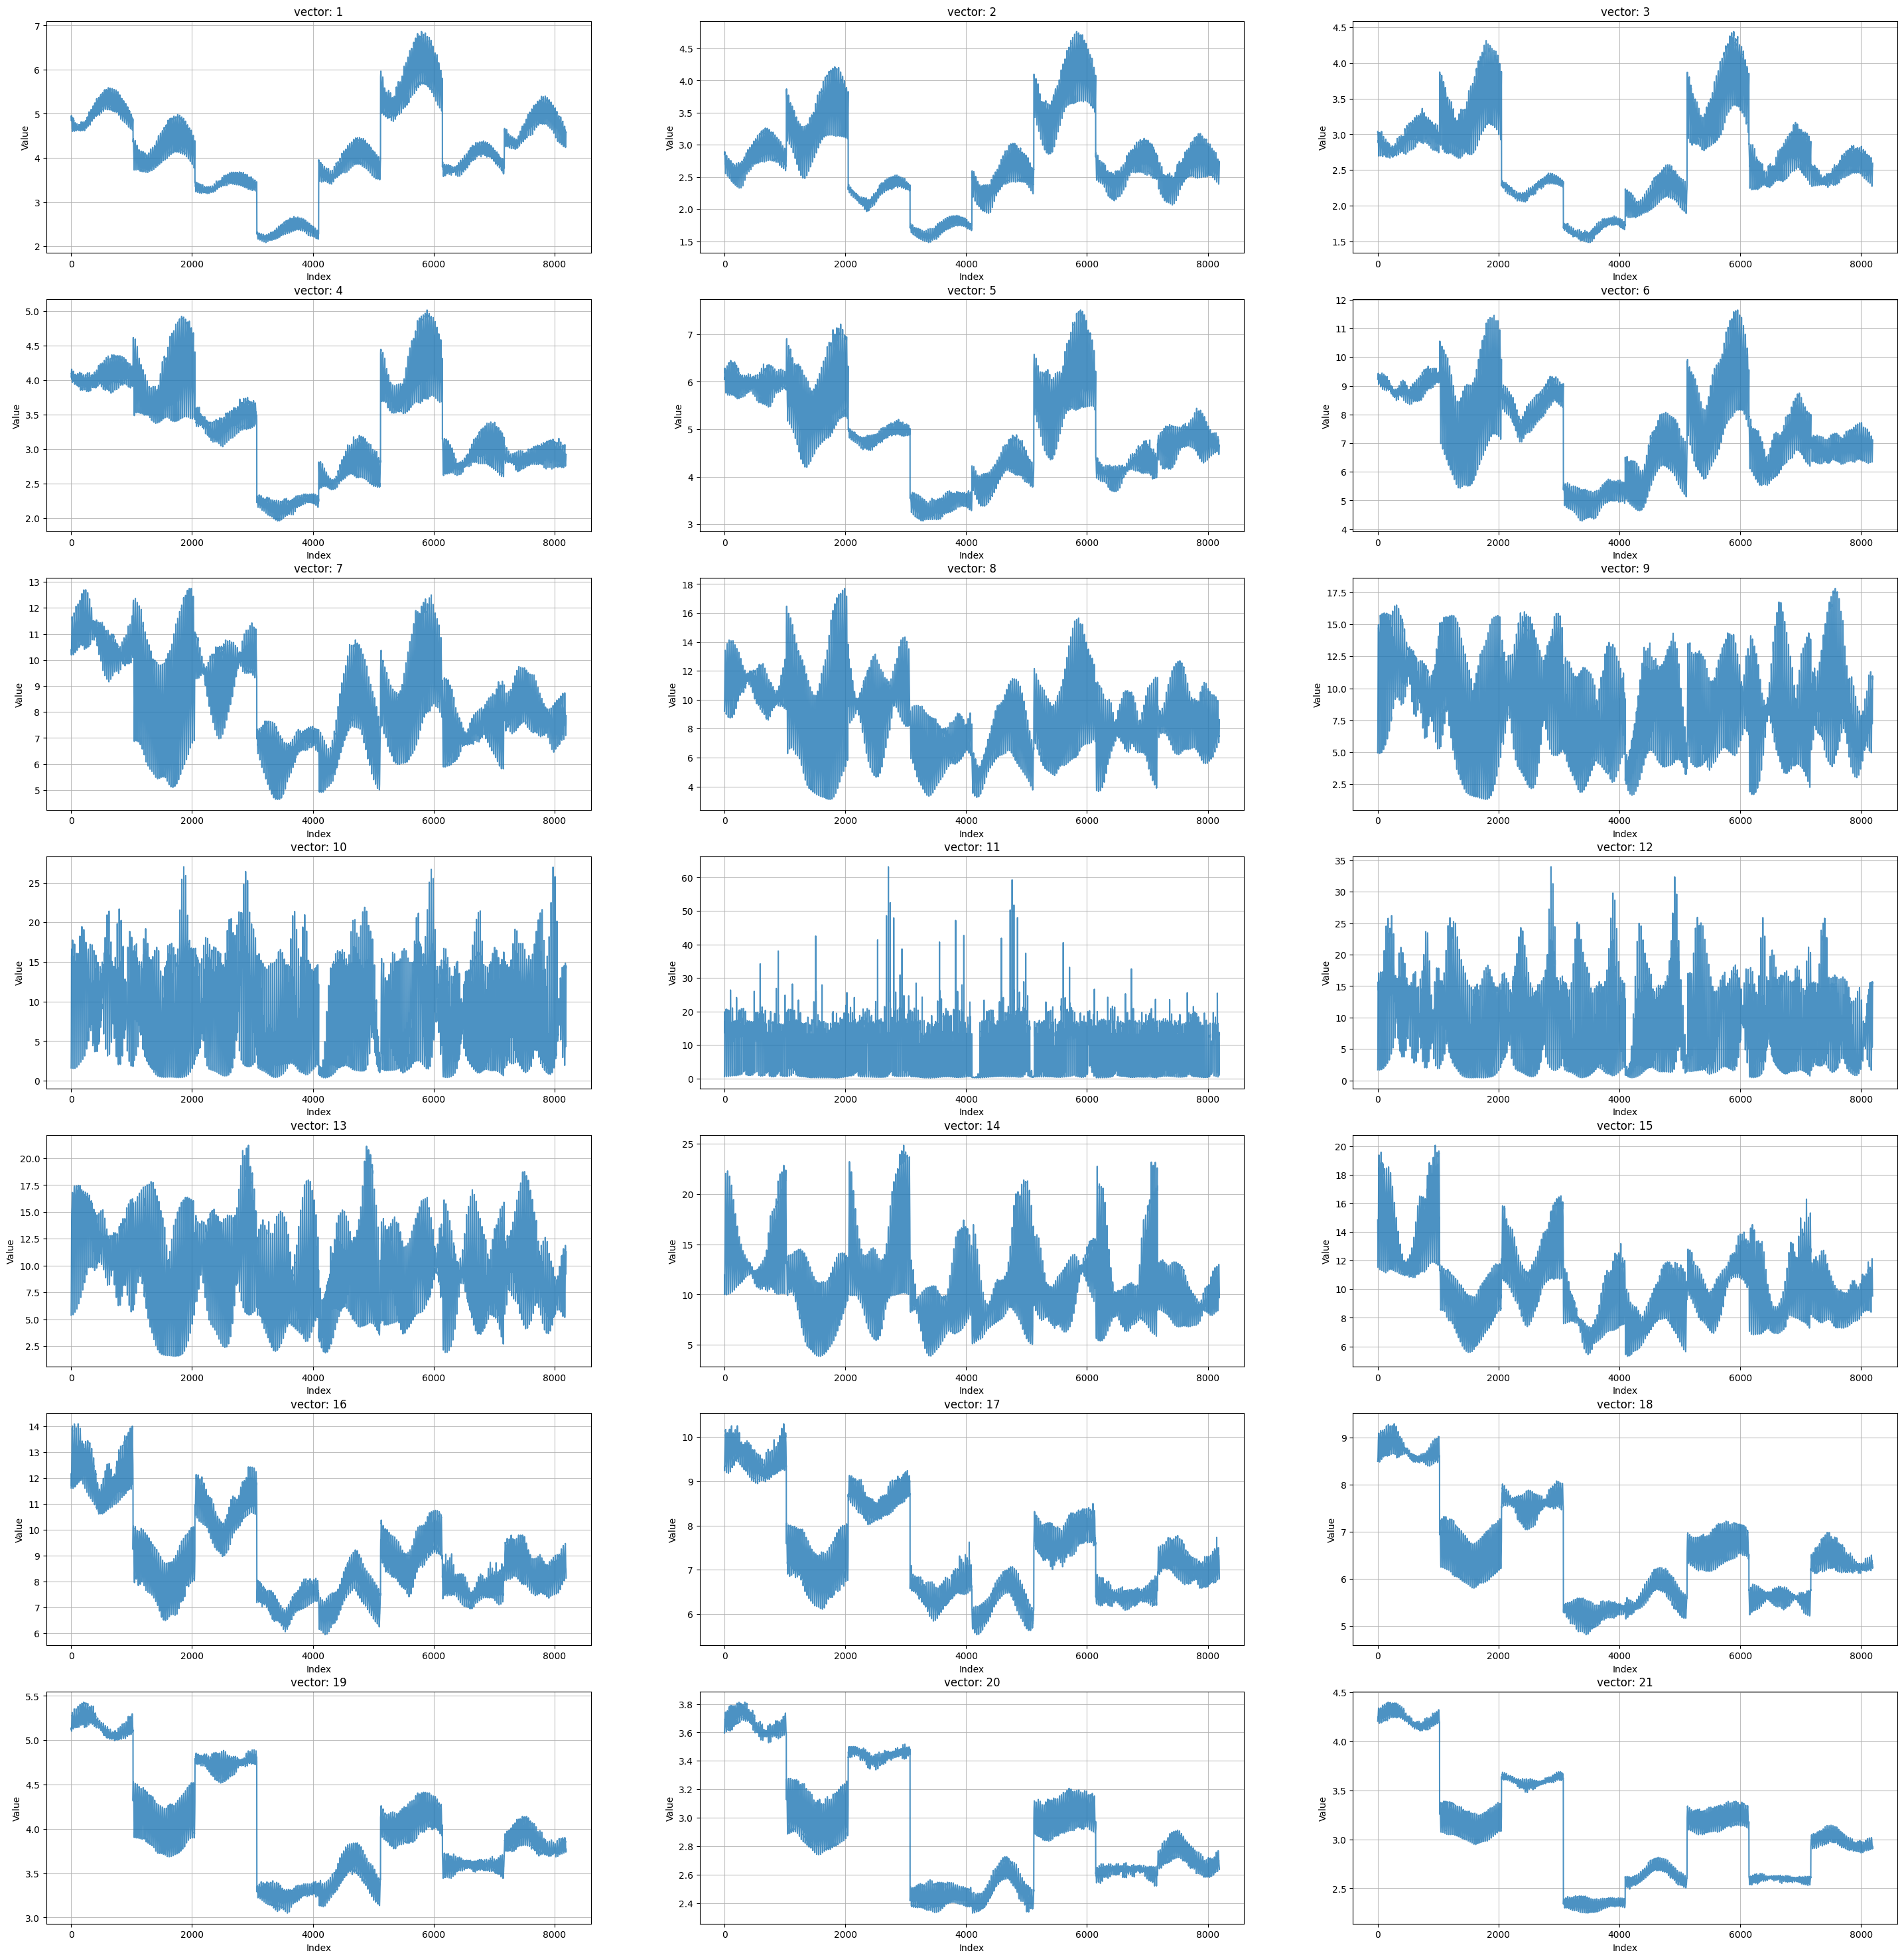

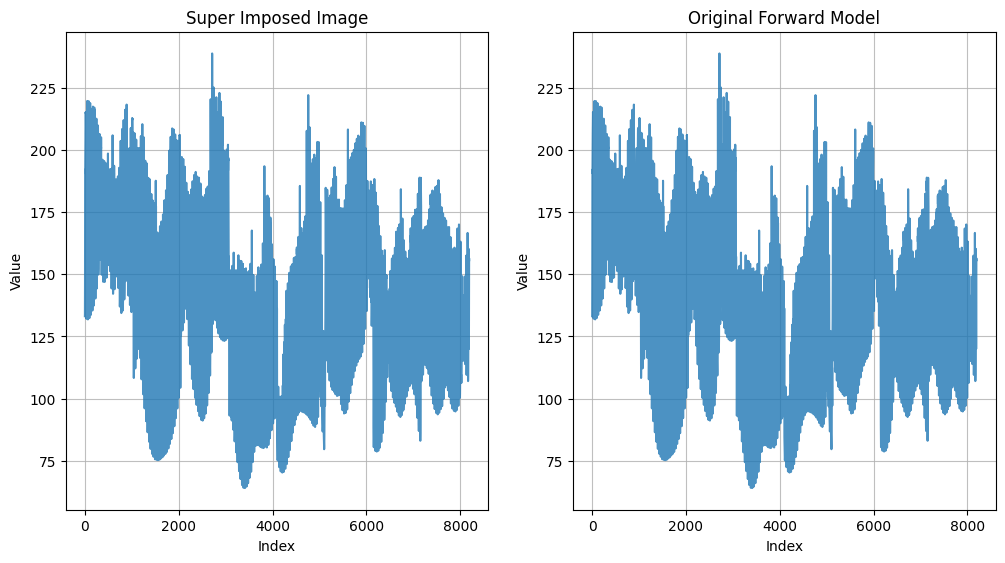

array([[1.        , 0.81978677],
       [0.81978677, 1.        ]])

In [6]:
fm.init_one_shot(m = 8)
det = fm.A@rd.X.flatten()
vec = None
V = []
for plane in range(Nz):
    cur_measure = fm.dc_extended_forward_model(rd.X, object_plane=plane)
    V.append(cur_measure.detach().cpu())
    if vec is None:
        vec = cur_measure
    else:
        vec = vec + cur_measure

vs.visualize_vectors(V,cols=3 ,same_fig=False, fig_size=(36,12))
vs.visualize_vectors([vec.detach().cpu(), det.detach().cpu()],titles=["Super Imposed Image", "Original Forward Model"], same_fig=False,fig_size=(12,2))
np.corrcoef(V[1].detach().cpu(), V[4].detach().cpu())